In [228]:
# $ source activate scr_analysis
% pylab inline
from pandas import read_csv
import pandas
import numpy as np
import os 

# let's turn off these error messages : https://tinyurl.com/ybduhkh3
pandas.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


/Users/ssnl_booth2/anaconda/envs/experimental/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [229]:
# EXTRACT DATA 

def loadData(path2data):
    """ 
    Load BIOPAC data converted to .txt files. Returns: 
    rawData[iSubject][iDay][:,iChannel], where 
    iChannel [0,1,2,3] are [scr, cs+, cs-, us] respectively
    """
    
    rawData = {}
    tmpFiles = os.listdir(path2data)

    for iFile in range(0,int(len(tmpFiles)/2)):
        tmp1 = read_csv('%s/%s'%(path2data,tmpFiles[ iFile * 2  ]), sep=',',header=None)
        tmp2 = read_csv('%s/%s'%(path2data,tmpFiles[iFile *2 + 1]), sep=',',header=None)
        rawData[iFile] = [tmp1.values, tmp2.values]

    return rawData

# And let's just make these prettier throughout the code

def nonZero(x): 
    return np.nonzero(x)[0]

In [ ]:
# LOAD DATA

path2data = os.getcwd() + '/scr_finalDataSet/'
raw_data = loadData(path2data)


In [ ]:
len(raw_data)

In [ ]:
# INSPECT DATA EXTRACTION

iSubject = 2
figure(figsize(15,6)); subplot(211); 
plot(raw_data[iSubject][0]); title('day 1 data')
legend(['scr','CS+','CS-','US'],bbox_to_anchor=(1, 1))

subplot(212); plot(raw_data[iSubject][1]); title('day 2 data'); 
legend(['scr','CS+','CS-','US'],bbox_to_anchor=(1, 1)); 


In [ ]:
def stimulus_markers(CS):
    """Generate list of timepoints for stimuli onset and offset."""
    
    # delta marks transitions to and from a CS
    compareA = np.append(nonZero(CS),nonZero(CS)[-1])
    compareB = np.append(nonZero(CS)[0],nonZero(CS))
    delta = compareA - compareB

    # identify stimulus onsets 
    on = zeros(len(CS))
    on[compareA[nonZero(delta > 1)]] = 1
    on[compareA[0]] = 1

    # identify stimulus offsets
    off= zeros(len(CS))
    off[compareA[nonZero(delta > 1)-1]] = 1
    off[compareA[-1]] = 1

    return nonZero(on), nonZero(off)


In [ ]:
# INSPECT CS+ AND CS- STIMULUS IDENTIFICATION ON A TEST SUBJECT

iSubject = 3  ; day = 0

# generate onset and offsets for each CS (pos and neg)
pos_onsets, pos_offsets = stimulus_markers(raw_data[iSubject][day][:,1])
neg_onsets, neg_offsets = stimulus_markers(raw_data[iSubject][day][:,2])

# plot scr data
figure(figsize(20,8))
subplot(211)
#plot locations of onsets 
plot(raw_data[iSubject][day][:,0])
plot(pos_onsets,raw_data[iSubject][day][pos_onsets,0],'r|',markersize=100,alpha=.7)
plot(neg_onsets,raw_data[iSubject][day][neg_onsets,0],'b|',markersize=100,alpha=.7)
plot(raw_data[iSubject][day][:,1:4]*5,alpha=.3)
ylim([min(raw_data[iSubject][day][:,0]),max(raw_data[iSubject][day][:,0])])
title('validating our onset locations')

# plot locations of offsets 
subplot(212)
plot(raw_data[iSubject][day][:,0])
plot(pos_offsets,raw_data[iSubject][day][pos_offsets,0],'r|',markersize=100,alpha=.7)
plot(neg_offsets,raw_data[iSubject][day][neg_offsets,0],'b|',markersize=100,alpha=.7)
plot(raw_data[iSubject][day][:,1:4]*5,alpha=.3)
ylim([min(raw_data[iSubject][day][:,0]),max(raw_data[iSubject][day][:,0])])
title('validating our offset locations'); 


In [ ]:
# IDENTIFY US STIMULUS PRESENTATION 

iSubject = 0 ; day = 1
pos_onsets, null = stimulus_markers(raw_data[iSubject][day - 1][:,1])
neg_onsets, null = stimulus_markers(raw_data[iSubject][day - 1][:,2])   
all_onsets = np.sort(np.concatenate([pos_onsets,neg_onsets]))

US = np.zeros(len(all_onsets))
USREF = np.zeros(len(all_onsets))

ucs_onsets, ucs_offsets = stimulus_markers(raw_data[iSubject][day - 1][:,3])
for iUS in range(0,len(ucs_onsets)): 
    difference = abs(all_onsets - ucs_offsets[iUS])
    US[np.nonzero(difference == min(difference))[0]] = 1

    differenceREF = abs(pos_onsets - ucs_offsets[iUS])
    USREF[np.nonzero(differenceREF == min(differenceREF))[0]] = 1
    

In [ ]:
# INSPECT US IDENTIFICATION 

day = 0
iSubject = 3
# plot scr data
figure(figsize(20,4))
#plot locations of onsets 
plot(raw_data[iSubject][day][:,0])
plot(pos_onsets,raw_data[iSubject][day][pos_onsets,0],'o',markersize=20,alpha=.2)
plot(all_onsets[nonZero(US)],raw_data[iSubject][day][all_onsets[nonZero(US)],0],'r.',markersize=15,alpha=.7)
#plot(all_onsets[nonZero(US)], raw_data[iSubject][day][:,1:4]*5,alpha=.3)
#ylim([min(raw_data[iSubject][day][:,0])-1,max(raw_data[iSubject][day][:,0])])
title('validating our US locations\n US blocks should be during the %s  CS+ blocks'%str(nonZero(USREF)+1) )
legend(['scr','CS+ blocks','US blocks']); 


In [ ]:
# EXTRACT STIMULI AND CREATE A DATA FRAME WITH RELEVENT INFORMATION

def design(raw_data, iSubject):
    """Create a data frame with the structure of the experiment. Necessary for modeling SCR data."""    
    
    def extract_design(raw_data, iSubject, day): 
        # identify positive and negative onsets across experiment -- only using onsets
        pos_onsets, null = stimulus_markers(raw_data[iSubject][day][:,1])
        neg_onsets, null = stimulus_markers(raw_data[iSubject][day][:,2])    
        
        # concatenate into a list and order 
        all_onsets = np.sort(np.concatenate([pos_onsets,neg_onsets]))
         
        # create placeholders
        CSpos = np.zeros(len(all_onsets))
        CSneg = np.zeros(len(all_onsets))
        US    = np.zeros(len(all_onsets))
        
        # for US
        if day == 0: 

            # identify locations for the US in the timecourse of the experiment
            us_onsets, us_offsets = stimulus_markers(raw_data[iSubject][day][:,3]) 
            # the '- 1' here is annoying, but necessary to automatically concatenate 
            # the two data frames in the right order ... 
            
            for eachUS in range(0,len(us_onsets)): 
                
                # find condition nearest to each US
                difference = abs(all_onsets - us_offsets[eachUS])
                # align timecourse differences with design placeholder 
                US[np.nonzero(difference == min(difference))[0]] = 1

        # for CS+ and CS-  
        for iOnset in range(0,len(all_onsets)): 
            
            # 
            CSpos[iOnset] = all_onsets[iOnset] in pos_onsets
            CSneg[iOnset] = all_onsets[iOnset] in neg_onsets
        
        # create a data frame with CS+, CS-, US, and the day
        structure = {'US':US, 'CS+': CSpos,'CS-':CSneg,'Day':repeat(day+1,len(all_onsets))}
        structure = pandas.DataFrame(structure) ; 
        # create column of indices for where event occured in scr timecourse         
        structure['CS_index'] = np.zeros(len(structure["CS+"]))
        structure['CS_index'][structure['CS+'] == 1] = pos_onsets 
        structure['CS_index'][structure['CS-'] == 1] = neg_onsets 
        
        return structure

    # determine the design on each day and concatenate the two
    design_day1 = extract_design(raw_data,iSubject,0)
    design_day2 = extract_design(raw_data,iSubject,1);
    design_full = pandas.concat([design_day1, design_day2])
    
    # clean up the fata frame
    design_full = design_full.reset_index()
    design_full.index.name = 'trial_number' # #    design_full.index += 1 ; 
    design_full['Day'] -= 1 # again, annoying, but because of the concatenation
    
    return design_full

In [ ]:
# GENERATE DATA FRAME -- still throws an error, 
# but it's just reformatting things into the new data frame :) 

test = design(raw_data, iSubject=0); 

test

In [ ]:
# INSPECT DATA FRAME FOR DESIGN STRUCTURE

figure(figsize(20,5))
plot(test['CS-'],alpha=.8)
plot(test['CS+'],alpha=.8)
plot(test['US'],'r--',linewidth=4,alpha=.2)
legend(['CS+','CS-','US'])
xlim([0,sum(test['Day'] == 1)])
title('CS and US presentation across day 1\n information extracter from data frame\n', fontsize=15); 


In [ ]:
# INSPECT ALIGNMENT BETWEEN DATAFRAME AND ORIGINAL DATA SCRUCTURE

iSubject = 0 ; iDay = 0; CS_type = 'CS+'

data_design = design(raw_data, iSubject)
CS_locations = nonZero((data_design["Day"] == iDay) & (data_design[CS_type] == 1))

iIndex = data_design['CS_index'][CS_locations]
iIndex = iIndex.as_matrix()

plot(raw_data[iSubject][iDay]); 
plot(iIndex, raw_data[iSubject][iDay][iIndex.astype(int),0], 'r|', markersize=100)
#ylim([4.9,5.3])
title('nice alignment between data frame and original format'); 


In [ ]:
# INSPECT AMPLITUDE EXTRACTION

iSubject = 0 ; iDay = 0 ; CS_type = 'US' ; iStimulus = 2

subject_timecourse = raw_data[iSubject][iDay][:,0]
data_design = design(raw_data, iSubject)
CS_locations = nonZero((data_design["Day"] == iDay) & (data_design[CS_type] == 1))
iIndex = data_design['CS_index'][CS_locations]
iIndex = iIndex.as_matrix()

# begin 1 second after stimulus onset 
interval_length = 4.5
onset = int(iIndex[iStimulus]) + 1000
interval_length = int(interval_length * 1000)

# define interval to search over + find max value and index 
max_interval = subject_timecourse[onset: onset + interval_length]
max_index = onset + max_interval.argmax()
max_value = subject_timecourse[max_index]

# define interval from onset to max + find min index and value
min_interval = subject_timecourse[onset:max_index] # NOTE: in original code this didn't use the same (+ 1 second) onset as above ... 
min_index = onset + min_interval.argmin()
min_value = subject_timecourse[min_index]

subplot(121)
plot(range(onset,len(max_interval)+onset),max_interval,'b--',linewidth=10,alpha=.3)
plot(range(onset,len(min_interval)+onset),min_interval,'r--')
plot(max_index,max_value,'b|', markersize=100,alpha=.6)
plot(min_index,min_value,'r|', markersize=100,alpha=.6)
legend(['max_interval','min_interval','max_ind','max_val'])
ylim([min(max_interval)-.2,max(max_interval)+.2]); 

subplot(122)
plot(range(onset,len(max_interval)+onset),max_interval,'b--',linewidth=10,alpha=.3)
plot(range(onset,len(min_interval)+onset),min_interval,'r--')
plot(raw_data[iSubject][iDay]); 
legend(['max_interval','min_interval']); 
title('seems like everything is in order...')

In [ ]:
def generate_onsets(design_matrix,iDay,CS_type):
    """Find onsets of a given CS type, on a given day, within the design matrix."""

    # find CS_type locations with the design that are on iDay
    CS_locations_TMP = nonZero((design_matrix["Day"] == iDay) & (design_matrix[CS_type] == 1))
    
    # find indices of CS_type within design
    indices = np.array(design_matrix['CS_index'][CS_locations_TMP])
    
    return indices

In [ ]:
def amplitude(subject_timecourse,onset): 
    """Find SCR amplitude from the onset of a CS over a given interval."""

    initial_delay = 1                             # length of wait time after onset
    interval_length = 4.5                         # length of interval to search over
    interval_length = int(interval_length * 1000) # convert to ms
    onset = onset + initial_delay * 1000          # convert to ms 
    
    # define interval to search over + find max value and index 
    max_interval = subject_timecourse[onset: onset + interval_length]
    max_index = onset + max_interval.argmax()
    max_value = subject_timecourse[max_index]

    # define interval from onset to max + find min index and value
    min_interval = subject_timecourse[onset:max_index] # NOTE: in original code this didn't use the same (+ 1 second) onset as above ... 
    min_index = onset + min_interval.argmin()
    min_value = subject_timecourse[min_index]
    
    return max_interval, max_index, max_value, min_interval, min_index, min_value

In [ ]:
# INSPECT generate_onsets() AND amplitude() FUNCTIONS 

iDay = 1; iSubject = 0; iStimulus = 0 ; CS_type = 'CS+'

# generate design matrix and extract onsets of CS_type
design_matrix = design(raw_data, iSubject)
onsets = generate_onsets(design_matrix,iDay,CS_type)

# identify the max and min interval, values, and indices of iStimulus of CS_type
onset = int(onsets[iStimulus])
subject_timecourse = raw_data[iSubject][iDay][:,0]
max_int, max_i, max_v, min_int, min_i, min_v = amplitude(subject_timecourse,onset)
original_onset = np.copy(onset)
original_onset = int(original_onset)
onset = onset + 1000


In [ ]:

plot(original_onset, raw_data[iSubject][iDay][original_onset,0],'rd',markersize=15,alpha=.4)
plot(max_i, raw_data[iSubject][iDay][max_i,0],'bd',markersize=15,alpha=.4)
plot(min_i, raw_data[iSubject][iDay][min_i,0],'gd',markersize=15,alpha=.4)
plot(range(onset,len(max_int)+onset),max_int,'b',linewidth=10,alpha=.3)
plot(range(onset,len(min_int)+onset),min_int,'r--',linewidth=7,alpha=.6)
plot(raw_data[iSubject][iDay])

legend(['stimulus onset','maximum location','minimum location','interval to compute maximum','interval to compute minumun','scr','CS+','CS-','US']); 
xlim([original_onset-10000,original_onset+20000])
title('things seem to be in order\n %s #%d on day %d\n'%(CS_type,iStimulus,iDay)); 


In [219]:
# INCLUDE US STIMULI INTO THE DATA FRAME 

def design(raw_data, iSubject):
    """Create a data frame with the structure and time indices of experimental stimuli."""    
    
    def extract_design(raw_data, iSubject, day): 
        # identify positive and negative onsets across experiment -- only using onsets
        pos_onsets, null = stimulus_markers(raw_data[iSubject][day][:,1])
        neg_onsets, null = stimulus_markers(raw_data[iSubject][day][:,2])    
        
        # concatenate into a list and order 
        all_onsets = np.sort(np.concatenate([pos_onsets,neg_onsets]))
         
        # create placeholders
        CSpos = np.zeros(len(all_onsets))
        CSneg = np.zeros(len(all_onsets))
        US    = np.zeros(len(all_onsets))

        # for CS+ and CS- on both days
        for iOnset in range(0,len(all_onsets)): 
            # 
            CSpos[iOnset] = all_onsets[iOnset] in pos_onsets
            CSneg[iOnset] = all_onsets[iOnset] in neg_onsets        
            
        # create a data frame with CS+, CS-, US, and the day
        structure = {'US':US, 'CS+': CSpos,'CS-':CSneg,'Day':repeat(day+1,len(all_onsets))}
        structure = pandas.DataFrame(structure) ; 
        
        # create column of indices for where event occured in scr timecourse         
        structure['CS_index'] = np.zeros(len(structure["CS+"]))
        structure['CS_index'][structure['CS+'] == 1] = pos_onsets 
        structure['CS_index'][structure['CS-'] == 1] = neg_onsets 
        structure['US_index'] = np.zeros(len(structure["US"]))
        
        # on day one, fill in the locations for the US
        if day == 0: 

            # identify locations for the US in the timecourse of the experiment
            us_onsets, us_offsets = stimulus_markers(raw_data[iSubject][day][:,3]) 
            
            # extract time of onset nearst to each US            
            for eachUS in range(0,len(us_onsets)): 
                
                # find condition nearest to each US
                difference = abs(all_onsets - us_offsets[eachUS])
                # align timecourse differences with design placeholder 
                US[np.nonzero(difference == min(difference))[0]] = 1
            
            structure['US'] = US
            structure['US_index'][structure['US'] == 1] = us_onsets 
        
        return structure
    
    # determine the design on each day and concatenate the two
    design_day1 = extract_design(raw_data,iSubject,0)
    design_day2 = extract_design(raw_data,iSubject,1);
    design_full = pandas.concat([design_day1, design_day2])
    
    # clean up the fata frame
    design_full = design_full.reset_index() #range(0,len(design_full['CS+']))
    design_full.index.name = 'trial_number' # #    design_full.index += 1 ; 
    design_full['Day'] -= 1 # again, annoying, but because of the concatenation
    
    return design_full

In [220]:
design_matrix = design(raw_data,iSubject) ; design_matrix

,index,CS+,CS-,Day,US,CS_index,US_index
trial_number,,,,,,,
0,0,1.0,0.0,0,0.0,130392.0,0.0
1,1,0.0,1.0,0,0.0,139413.0,0.0
2,2,0.0,1.0,0,0.0,150414.0,0.0
3,3,1.0,0.0,0,0.0,159416.0,0.0
4,4,0.0,1.0,0,0.0,170420.0,0.0
5,5,1.0,0.0,0,0.0,181420.0,0.0
6,6,0.0,1.0,0,0.0,190422.0,0.0
7,7,1.0,0.0,0,1.0,201424.0,205335.0
8,8,0.0,1.0,0,0.0,212434.0,0.0


IndexError: index 459499 is out of bounds for axis 1 with size 432704

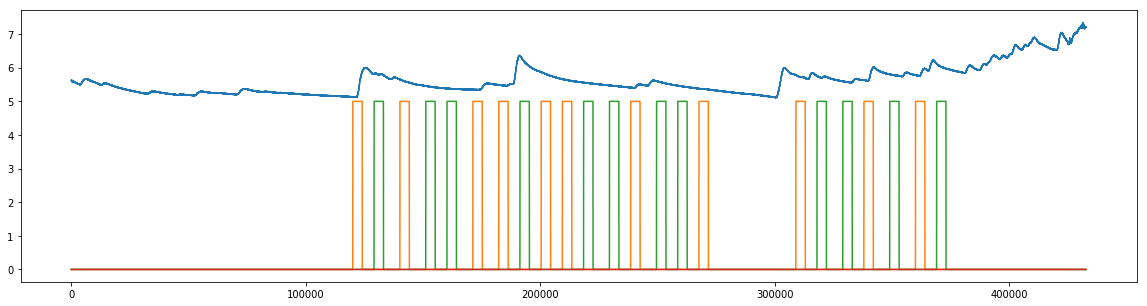

In [226]:
# VALIDATE INCLUSION OF US IN DATA

iDay = 1  ; iSubject = 10  ; iStimulus = 2 ; CS_type = 'CS+'

subjectSCR = raw_data[iSubject][iDay][:,0]
design_matrix = design(raw_data,iSubject)
tmpINT = design_matrix.CS_index[design_matrix[CS_type]==1].values

plot(raw_data[iSubject][iDay])
plot(tmpINT.astype(int), subjectSCR[tmpINT.astype(int)],'r|',markersize=100);

In [176]:
# INCLUDE US STIMULI INTO THE DATA FRAME AND ENABLE FOR MULTIPLE SUBJECTS 

def design_(raw_data):
    """Create a data frame with the structure and time indices of experimental stimuli."""    
    
    nSubjects = len(raw_data)
    all_subjects_design = {}
    
    for iSubject in range(0,nSubjects): 
        
        # determine the design on each day and concatenate the two
        design_day1 = extract_design(raw_data[iSubject],0)
        design_day2 = extract_design(raw_data[iSubject],1);
        design_full = pandas.concat([design_day1, design_day2])

        # clean up the fata frame
        design_full = design_full.reset_index() # range(0,len(design_full['CS+']))
        design_full.index.name = 'trial_number' # #    design_full.index += 1 ; 
        design_full['Day'] -= 1 # again, annoying, but because of the concatenation
        all_subjects_design[iSubject] = design_full

    return all_subjects_design


def extract_design(subject_data, day): 
    
    # identify positive and negative onsets across experiment -- only using onsets
    pos_onsets, null = stimulus_markers(subject_data[day][:,1])
    neg_onsets, null = stimulus_markers(subject_data[day][:,2])    
    
    # concatenate into a list and order 
    all_onsets = np.sort(np.concatenate([pos_onsets,neg_onsets]))

    # create placeholders
    CSpos = np.zeros(len(all_onsets))
    CSneg = np.zeros(len(all_onsets))
    US    = np.zeros(len(all_onsets))

    # for CS+ and CS- on both days
    for iOnset in range(0,len(all_onsets)): 
        
        CSpos[iOnset] = all_onsets[iOnset] in pos_onsets
        CSneg[iOnset] = all_onsets[iOnset] in neg_onsets        

    # create a data frame with CS+, CS-, US, and the day
    structure = {'US':US, 'CS+': CSpos,'CS-':CSneg,'Day':repeat(day+1,len(all_onsets))}
    structure = pandas.DataFrame(structure) ; 

    # create column of indices for where event occured in scr timecourse         
    structure['CS_index'] = np.zeros(len(structure["CS+"]))
    structure['CS_index'][structure['CS+'] == 1] = pos_onsets 
    structure['CS_index'][structure['CS-'] == 1] = neg_onsets 
    structure['US_index'] = np.zeros(len(structure["US"]))

    # on day one, fill in the locations for the US
    if day == 0: 

        # identify locations for the US in the timecourse of the experiment
        us_onsets, us_offsets = stimulus_markers(subject_data[day][:,3]) 

        # extract time of onset nearst to each US            
        for eachUS in range(0,len(us_onsets)): 

            # find condition nearest to each US
            difference = abs(all_onsets - us_offsets[eachUS])
            # align timecourse differences with design placeholder 
            US[np.nonzero(difference == min(difference))[0]] = 1

        structure['US'] = US
        structure['US_index'][structure['US'] == 1] = us_onsets 

    return structure

In [177]:
path2data = os.getcwd() + '/scr_finalDataSet/'
raw_data = loadData(path2data)

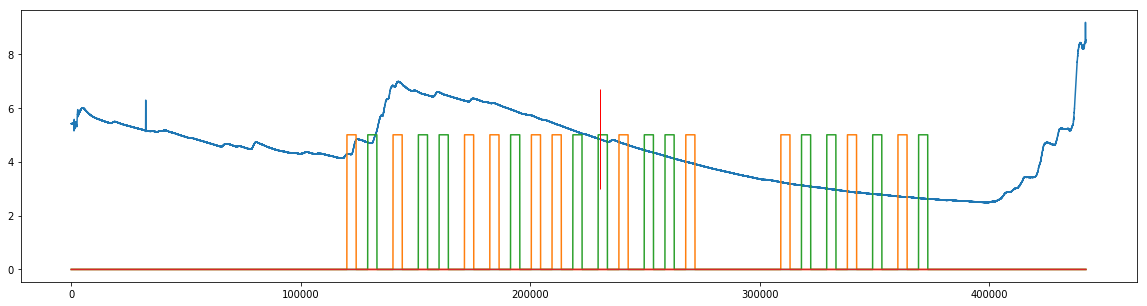

In [178]:
# VALIDATE INCLUSION OF US IN DATA

iDay = 1 ; iSubject = 4  ; iStimulus = 5

subjectSCR = raw_data[iSubject][iDay][:,0]
design_matrix = design_(raw_data)
tmpINT = design_matrix[iSubject].CS_index[design_matrix[iSubject]['CS+']==1].values

plot(raw_data[iSubject][iDay])
plot(int(tmpINT[iStimulus]), subjectSCR[int(tmpINT[iStimulus])],'r|',markersize=100);

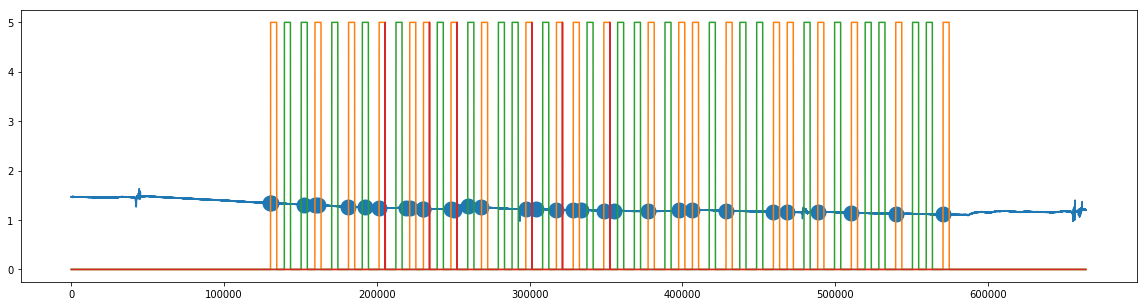

In [218]:
iDay = 0 ; iSubject = 1  ; iStimulus = 0 ; stim_type = 'CS+'

tmpINT = design_matrix[iSubject].CS_index[design_matrix[iSubject][stim_type]==1].values
subjectSCR = raw_data[iSubject][iDay][:,0]

plot(raw_data[iSubject][iDay])
scatter(tmpINT.astype(int), subjectSCR[tmpINT.astype(int)], linewidth=10);

IndexError: index 428500 is out of bounds for axis 1 with size 423598

In [210]:
tmpINT.astype(int)

array([130392, 159416, 181420, 201424, 221447, 230448, 248454, 268457,
       297464, 317470, 328481, 348484, 377498, 397494, 406497, 428500,
       459506, 468510, 488512, 510516, 539524, 570528, 130098, 152139,
       161172, 192241, 219342, 230375, 250409, 259443, 304345, 333359,
       355371])

In [39]:
# FORMAT RAW DATA INTO A DATA FRAME FOR CLARITY AND INSPECT OUTPUTS 

In [40]:

data_path = '/Users/ssnl_booth2/sSL/cleaning_scripts_study1/scr_finalDataSet/'
# there are two files for each subject, which will determine how we load data


def load_data(data_path):
    
    # set variables, load file names
    data = {}
    files = os.listdir(data_path)

    for iSubject in range(0,int(len(files)/2)):

        # set subject variables
        day = {}

        # load day 1 data and convert to data frame
        tmp_1    = read_csv('%s/%s'%(data_path,files[iSubject * 2]), sep=',',header=None)
        day_1 = pandas.DataFrame({'SCR': tmp_1.values[:,0], 'CS+' : tmp_1.values[:,1], 
                                  'CS-': tmp_1.values[:,2], 'US'  : tmp_1.values[:,3], 'Day':repeat(0,len(tmp1))})
        day[0] = day_1

        # load day 2 data and convert to data frame
        tmp_2 = read_csv('%s/%s'%(data_path,files[iSubject * 2 + 1]), sep=',',header=None)
        day_2 = pandas.DataFrame({'SCR': tmp_2.values[:,0], 'CS+': tmp_2.values[:,1], 
                                  'CS-': tmp_2.values[:,2], 'US' : tmp_2.values[:,3], 'Day':repeat(1,len(tmp2))})
        day[1] = day_2
        
        data[iSubject] = day
        
    return data

In [41]:
iSubject = 35
iDay = 1
plot(data[iSubject][iDay]['SCR'])
plot(data[iSubject][iDay]['CS+'])
plot(data[iSubject][iDay]['CS-'])
plot(data[iSubject][iDay]['US'])


NameError: name 'data' is not defined

In [42]:
def stimulus_markers(CS):
    """Generate list of timepoints for stimuli onset and offset."""
    
    # delta marks transitions to and from a CS
    compareA = np.append(nonZero(CS),nonZero(CS)[-1])
    compareB = np.append(nonZero(CS)[0],nonZero(CS))
    delta = compareA - compareB

    # identify stimulus onsets 
    on = zeros(len(CS))
    on[compareA[nonZero(delta > 1)]] = 1
    on[compareA[0]] = 1

    # identify stimulus offsets
    off= zeros(len(CS))
    off[compareA[nonZero(delta > 1)-1]] = 1
    off[compareA[-1]] = 1

    return nonZero(on), nonZero(off)


In [43]:
# INSPECT CS+ AND CS- STIMULUS IDENTIFICATION ON A TEST SUBJECT

iSubject = 42  ; day = 0

# generate onset and offsets for each CS (pos and neg)
pos_onsets, pos_offsets = stimulus_markers(data[iSubject][day]['CS+'])
neg_onsets, neg_offsets = stimulus_markers(data[iSubject][day]['CS-'])

# plot scr data
figure(figsize(20,8))
subplot(211)
#plot locations of onsets 
plot(data[iSubject][day]['SCR'])
plot(pos_onsets,data[iSubject][day]['SCR'][pos_onsets].values,'r|',markersize=100,alpha=.7)
plot(neg_onsets,data[iSubject][day]['SCR'][neg_onsets].values,'b|',markersize=100,alpha=.7)
#plot(data[iSubject][day][:,1:4]*5,alpha=.3)
ylim([min(data[iSubject][day]['SCR']),max(data[iSubject][day]['SCR'])])
title('validating our onset locations')
#legend(['scr','+ onsets','- onsets'])

plot(data[iSubject][iDay]['SCR'])
plot(data[iSubject][iDay]['CS+'])
plot(data[iSubject][iDay]['CS-'])
plot(data[iSubject][iDay]['US'])

#plot locations of onsets 
subplot(212)
plot(data[iSubject][day]['SCR'])
plot(pos_offsets,data[iSubject][day]['SCR'][pos_offsets].values,'r|',markersize=100,alpha=.7)
plot(neg_offsets,data[iSubject][day]['SCR'][neg_offsets].values,'b|',markersize=100,alpha=.7)
#plot(data[iSubject][day][:,1:4]*5,alpha=.3)
ylim([min(data[iSubject][day]['SCR']),max(data[iSubject][day]['SCR'])])
title('validating our onset locations')

plot(data[iSubject][iDay]['SCR'])
plot(data[iSubject][iDay]['CS+'])
plot(data[iSubject][iDay]['CS-'])
plot(data[iSubject][iDay]['US'])


NameError: name 'data' is not defined

In [44]:
#data[iSubject][0]

In [45]:
# identify positive and negative onsets across experiment -- only using onsets
subject_data = data[iSubject]
pos_onsets, null = stimulus_markers(subject_data[day]['CS+'])
neg_onsets, null = stimulus_markers(subject_data[day]['CS-'])    

# concatenate into a list and order 
all_onsets = np.sort(np.concatenate([pos_onsets,neg_onsets]))

NameError: name 'data' is not defined

In [46]:
subject_data = data[iSubject][1]
shape(subject_data)

NameError: name 'data' is not defined

In [47]:
shape(raw_data[iSubject][0][:,1])

KeyError: 42

In [48]:
subject_data1 = raw_data[iSubject]
stimulus_markers(subject_data1[day][:,1])

KeyError: 42

In [49]:
subject_data2 = data[iSubject]

stimulus_markers(subject_data2[day]['CS+'])

NameError: name 'data' is not defined

In [50]:
# INCLUDE US STIMULI INTO THE DATA FRAME AND ENABLE FOR MULTIPLE SUBJECTS

def MOOK(data):
    """Create a data frame with the structure and time indices of experimental stimuli."""    
    
    nSubjects = 1 # len(data)
    all_subjects_design = {}
    
    for iSubject in range(0,nSubjects): 
        
        # determine the design on each day and concatenate the two
        design_day1 = BOOK(data[iSubject],1)
        design_day2 = BOOK(data[iSubject],0);
        design_full = pandas.concat([design_day1, design_day2])

        # clean up the fata frame
        design_full = design_full.reset_index(range(0,len(design_full['CS+'])))
        design_full.index.name = 'trial_number' # #    design_full.index += 1 ; 
        design_full['Day'] -= 1 # again, annoying, but because of the concatenation
        all_subjects_design[iSubject] = design_full

    return all_subjects_design


def BOOK(subject_data, day): 
    
    # identify positive and negative onsets across experiment -- only using onsets
    pos_onsets, null = stimulus_markers(subject_data[day]['CS+'])
    neg_onsets, null = stimulus_markers(subject_data[day]['CS-'])    

    # concatenate into a list and order 
    all_onsets = np.sort(np.concatenate([pos_onsets,neg_onsets]))
    # create placeholders
    CSpos = np.zeros(len(all_onsets))
    CSneg = np.zeros(len(all_onsets))
    US    = np.zeros(len(all_onsets))

    # for CS+ and CS- on both days
    for iOnset in range(0,len(all_onsets)): 
        
        CSpos[iOnset] = all_onsets[iOnset] in pos_onsets
        CSneg[iOnset] = all_onsets[iOnset] in neg_onsets        

    # create a data frame with CS+, CS-, US, and the day
    structure = {'US':US, 'CS+': CSpos,'CS-':CSneg,'Day':repeat(day+1,len(all_onsets))}
    structure = pandas.DataFrame(structure) ; 

    # create column of indices for where event occured in scr timecourse         
    structure['CS_index'] = np.zeros(len(structure["CS+"]))
    structure['CS_index'][structure['CS+'] == 1] = pos_onsets 
    structure['CS_index'][structure['CS-'] == 1] = neg_onsets 
    structure['US_index'] = np.zeros(len(structure["US"]))

    # on day one, fill in the locations for the US
    if day == 0: 

        # identify locations for the US in the timecourse of the experiment
        us_onsets, us_offsets = stimulus_markers(subject_data[day]['US']) 

        # extract time of onset nearst to each US            
        for eachUS in range(0,len(us_onsets)): 

            # find condition nearest to each US
            difference = abs(all_onsets - us_offsets[eachUS])
            # align timecourse differences with design placeholder 
            US[np.nonzero(difference == min(difference))[0]] = 1

        structure['US'] = US
        structure['US_index'][structure['US'] == 1] = us_onsets 

    return structure

In [51]:
def stimulus_markers(CS):
    """Generate list of timepoints for stimuli onset and offset."""
    
    # delta marks transitions to and from a CS
    compareA = np.append(nonZero(CS),nonZero(CS)[-1])
    compareB = np.append(nonZero(CS)[0],nonZero(CS))
    delta = compareA - compareB

    # identify stimulus onsets 
    on = zeros(len(CS))
    on[compareA[nonZero(delta > 1)]] = 1
    on[compareA[0]] = 1

    # identify stimulus offsets
    off= zeros(len(CS))
    off[compareA[nonZero(delta > 1)-1]] = 1
    off[compareA[-1]] = 1

    return nonZero(on), nonZero(off)


In [52]:

sub = data[iSubject][0]
pos_onsets, null = stimulus_markers(sub['CS+'])
neg_onsets, null = stimulus_markers(sub['CS-'])    
print(len(pos_onsets),len(neg_onsets))

NameError: name 'data' is not defined

In [53]:
plot(data[0][0]['CS+'])
plot(data[0][0]['CS-'])

NameError: name 'data' is not defined

In [54]:
shape(data[0][1])

NameError: name 'data' is not defined

In [55]:
raw_data[iSubject]

KeyError: 42

In [56]:
# # VALIDATE INCLUSION OF US IN DATA

# iDay = 1  ; iSubject = 0  ; iStimulus = 2 

# subjectSCR = data[iSubject][iDay]['SCR']
design_matrix = MOOK(data)
# #tmpINT = design_matrix[iSubject].CS_index[(design_matrix[iSubject]['CS+']==1 & design_matrix[iSubject]['Day']==1)].values

# plot(data[iSubject][iDay]['SCR'])
# plot(data[iSubject][iDay]['SCR'])
# plot(data[iSubject][iDay]['CS+'])
# plot(data[iSubject][iDay]['CS-'])
# plot(data[iSubject][iDay]['US']*1.3)
# plot(int(tmpINT[iStimulus]), subjectSCR[int(tmpINT[iStimulus])],'r|',markersize=100);

NameError: name 'data' is not defined

In [692]:
design_matrix[iSubject]['Day'].values==1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [519]:
# GENERATE DATA FRAME 

iSubject = 0
design_matrix = design_TEST(data) ; design_matrix[3]


,index,CS+,CS-,Day,US,CS_index,US_index
trial_number,,,,,,,
0,0,1.0,0.0,0,0.0,9032.0,0.0
1,1,0.0,1.0,0,0.0,18052.0,0.0
2,2,0.0,1.0,0,0.0,29055.0,0.0
3,3,1.0,0.0,0,0.0,38057.0,0.0
4,4,0.0,1.0,0,0.0,49057.0,0.0
5,5,1.0,0.0,0,0.0,60070.0,0.0
6,6,0.0,1.0,0,0.0,69073.0,0.0
7,7,1.0,0.0,0,1.0,80076.0,83984.0
8,8,0.0,1.0,0,0.0,91085.0,0.0


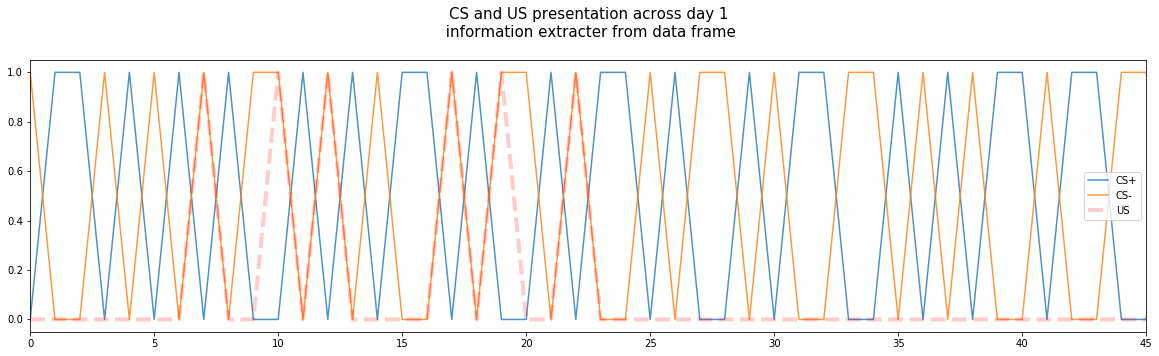

In [480]:
# INSPECT DATA FRAME FOR DESIGN STRUCTURE

figure(figsize(20,5))
plot(design_matrix[iSubject]['CS-'],alpha=.8)
plot(design_matrix[iSubject]['CS+'],alpha=.8)
plot(design_matrix[iSubject]['US'],'r--',linewidth=4,alpha=.2)
legend(['CS+','CS-','US'])
xlim([0,sum(design_matrix[iSubject]['Day'] == 1)])
title('CS and US presentation across day 1\n information extracter from data frame\n', fontsize=15); 


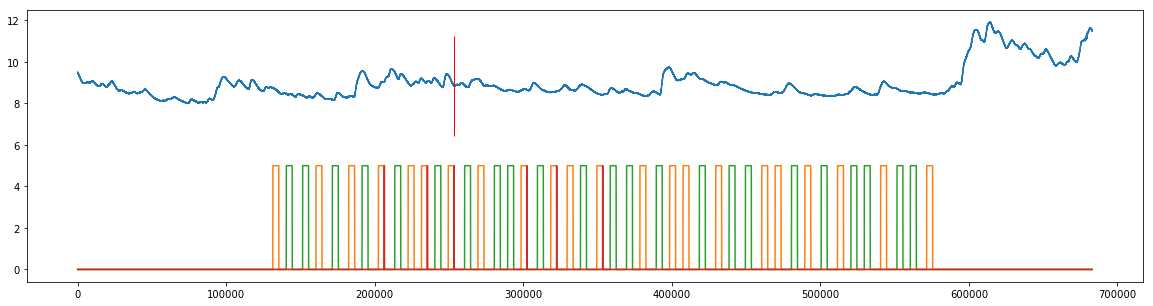

In [483]:
# VALIDATE INCLUSION OF US IN DATA

iDay = 0  ; iSubject = 40  ; iStimulus = 2

plot(data[iSubject][iDay]['SCR'])
plot(data[iSubject][iDay]['CS+'])
plot(data[iSubject][iDay]['CS-'])
plot(data[iSubject][iDay]['US'])

subjectSCR = data[iSubject][iDay]['SCR']
tmpINT = design_matrix[iSubject].US_index[design_matrix[iSubject]['US']==1].values
plot(int(tmpINT[iStimulus]), subjectSCR[int(tmpINT[iStimulus])],'r|',markersize=100);


In [484]:
def generate_onsets(design_matrix,iDay,CS_type):
    """Find onsets of a given CS type, on a given day, within the design matrix."""

    # find CS_type locations with the design that are on iDay
    CS_locations_TMP = nonZero((design_matrix["Day"] == iDay) & (design_matrix[CS_type] == 1))
    
    # find indices of CS_type within design
    indices = np.array(design_matrix['CS_index'][CS_locations_TMP])
    
    return indices

In [485]:
def amplitude(subject_timecourse,onset): 
    """Find SCR amplitude from the onset of a CS over a given interval."""

    initial_delay = 1                             # length of wait time after onset
    interval_length = 4.5                         # length of interval to search over
    interval_length = int(interval_length * 1000) # convert to ms
    onset = onset + initial_delay * 1000          # convert to ms 
    
    # define interval to search over + find max value and index 
    max_interval = subject_timecourse[onset: onset + interval_length]
    max_index = onset + max_interval.argmax()
    max_value = subject_timecourse[max_index]

    # define interval from onset to max + find min index and value
    min_interval = subject_timecourse[onset:max_index] # NOTE: in original code this didn't use the same (+ 1 second) onset as above ... 
    min_index = onset + min_interval.argmin()
    min_value = subject_timecourse[min_index]
    
    return max_interval, max_index, max_value, min_interval, min_index, min_value

In [493]:
# INSPECT generate_onsets() AND amplitude() FUNCTIONS 

iDay = 1; iSubject = 15; iStimulus = 0 ; CS_type = 'CS+'

# generate design matrix and extract onsets of CS_type
onsets = generate_onsets(design_matrix[iSubject], iDay, CS_type)

# identify the max and min interval, values, and indices of iStimulus of CS_type
onset = int(onsets[iStimulus])
subject_timecourse = data[iSubject][iDay]['SCR']
max_int, max_i, max_v, min_int, min_i, min_v = amplitude(subject_timecourse,onset)
original_onset = np.copy(onset)
original_onset = int(original_onset)
onset = onset + 1000


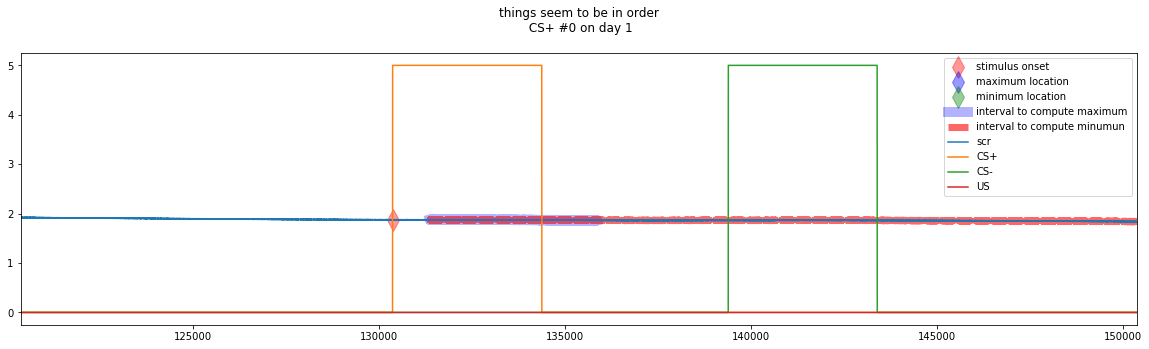

In [494]:

plot(original_onset, data[iSubject][iDay]['SCR'].values[original_onset],'rd',markersize=15,alpha=.4)
plot(max_i, data[iSubject][iDay]['SCR'].values[max_i],'bd',markersize=15,alpha=.4)
plot(min_i, data[iSubject][iDay]['SCR'].values[min_i],'gd',markersize=15,alpha=.4)
plot(range(onset,len(max_int)+onset),max_int,'b',linewidth=10,alpha=.3)
plot(range(onset,len(min_int)+onset),min_int,'r--',linewidth=7,alpha=.6)
plot(data[iSubject][iDay]['SCR'])
plot(data[iSubject][iDay]['CS+'])
plot(data[iSubject][iDay]['CS-'])
plot(data[iSubject][iDay]['US'])


legend(['stimulus onset','maximum location','minimum location','interval to compute maximum','interval to compute minumun','scr','CS+','CS-','US']); 
xlim([original_onset-10000,original_onset+20000])
title('things seem to be in order\n %s #%d on day %d\n'%(CS_type,iStimulus,iDay)); 
